## Wine quality

Can we build a model that can be used to determine the quality of a wine? Quality has been measured on a scale of 1-10. Lets define quality as anything equalling 7 or above, and make this a classification problem. 

In [189]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_columns", None)

In [36]:
df = pd.read_csv("winequality-red.csv", sep=";")
df["is_quality"] = np.where(df["quality"] >= 7, 1, 0)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,is_quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0


## Data exploration

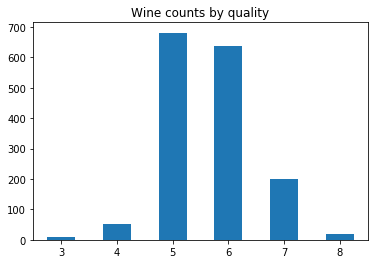

In [37]:
fig, ax = plt.subplots(1, 1)
df["quality"].value_counts().sort_index().plot(kind="bar", rot=0, ax=ax)
ax.set_title("Wine counts by quality");

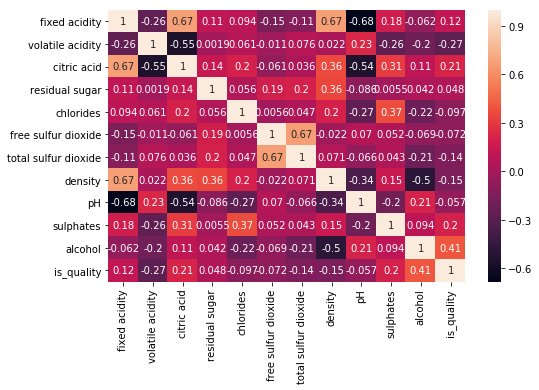

In [38]:
corr = df.drop(labels=["quality"], axis=1).corr()
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
sns.heatmap(corr, annot=True, ax=ax);

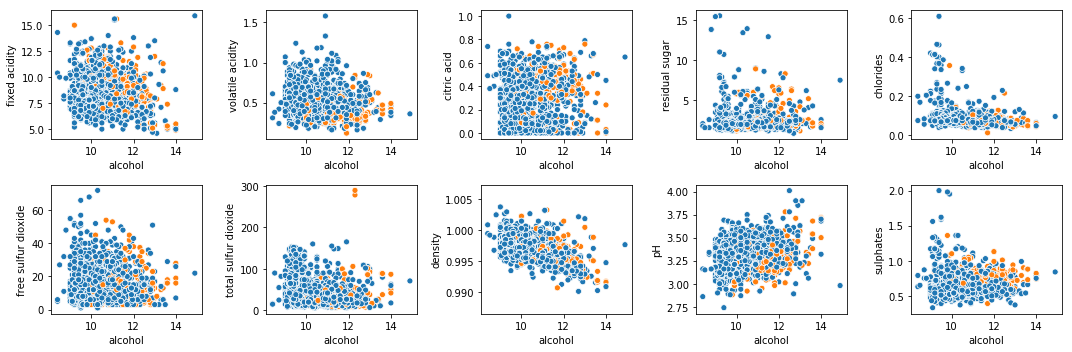

In [63]:
fig, axes = plt.subplots(2, 5, figsize=(15, 5))
cols = df.drop(labels=["is_quality", "alcohol", "quality"], axis=1).columns

x1 = df["alcohol"]

for ax, col in zip(axes.flat, cols):
    x2 = df[col]
    sns.scatterplot(x=x1, y=x2, hue=df["is_quality"], ax=ax, legend=False)
plt.tight_layout() 

From an intial plot, we don't see much separation between classes. 

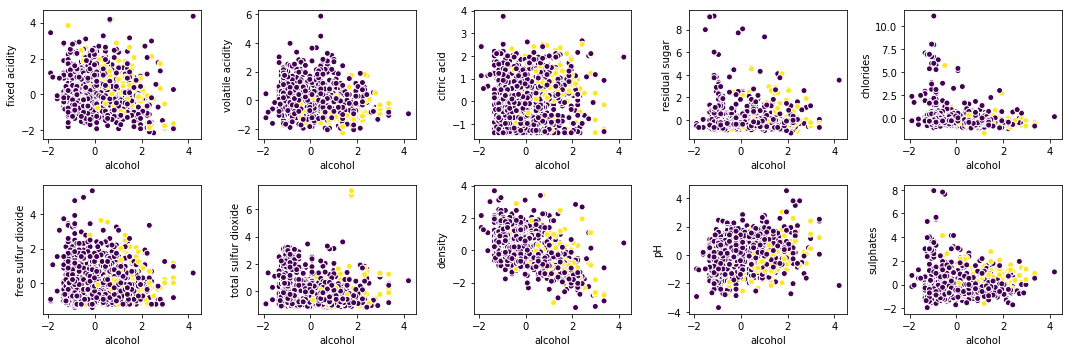

In [67]:
from sklearn.preprocessing import StandardScaler

fig, axes = plt.subplots(2, 5, figsize=(15, 5))
cols = df.drop(labels=["is_quality", "alcohol", "quality"], axis=1).columns

ss = StandardScaler()
x1 = df["alcohol"]
x1 = ss.fit_transform(x1.values.reshape(-1,1))

for ax, col in zip(axes.flat, cols):
    x2 = ss.fit_transform(df[col].values.reshape(-1, 1))
    ax.scatter(x1, x2, c=df["is_quality"].values.reshape(-1, 1), edgecolors="w")
    ax.set_ylabel(col)
    ax.set_xlabel("alcohol")

plt.tight_layout()    

Scaling the features helps us compare separation between x,y due to even scales.

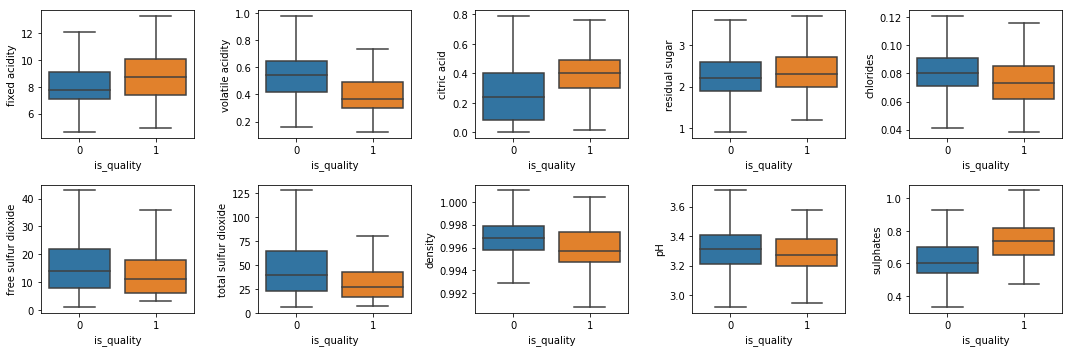

In [79]:
fig, axes = plt.subplots(2, 5, figsize=(15, 5))
cols = df.drop(labels=["is_quality", "alcohol", "quality"], axis=1).columns

for ax, col in zip(axes.flat, cols):
    sns.boxplot(x=df["is_quality"], y=df[col], showfliers=False, ax=ax)
plt.tight_layout() 

## Modelling

It's an imbalanced class problem. We can potentially try out some resampling methods.

In [93]:
X_ = df.drop(labels=["quality", "is_quality"], axis=1)
y = df["is_quality"]

# Lets scale all features first.
ss = StandardScaler()
X = pd.DataFrame(ss.fit_transform(X_), columns=X_.columns)

print(y.value_counts())

0    1382
1     217
Name: is_quality, dtype: int64


In [143]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Artificial sample-generator
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, precision_recall_curve

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

To give us an idea of where to start, why not try a range of models? The features in our dataset are straightforward, so there are no real restrictions we need to consider. 

After we narrow down a potential model, then we can fine tune our approach. 

The precision-recall curve shows the tradeoff between precision and recall for different threshold. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

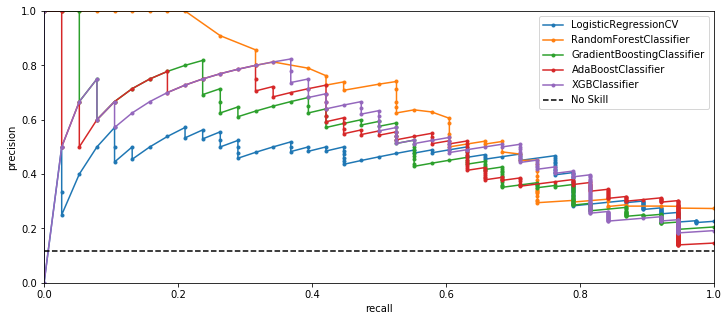

In [130]:
models = [
    LogisticRegressionCV(), 
    RandomForestClassifier(n_estimators=100), 
    GradientBoostingClassifier(n_estimators=100), 
    AdaBoostClassifier(n_estimators=100),
    XGBClassifier(n_estimators=100)
]

fig, ax = plt.subplots(1, 1, figsize=(12, 5))

for mod in models:
    name = type(mod).__name__
    mod.fit(X_train, y_train)
    probs = mod.predict_proba(X_test)[:, 1]
    
    # Get precision/recall
    precision, recall, thresholds = precision_recall_curve(y_test, probs)
    ax.plot(recall, precision, marker='.', label=name)
    ax.set_ylabel("precision")
    ax.set_xlabel("recall")

no_skill = len(y_test[y_test==1]) / len(y_test)
ax.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill', c="k")
ax.set_ylim(0, 1)
ax.set_xlim(0, 1)
ax.legend();

Although we have an imbalanced class problem, it's ok to use accuracy to judge relative performance improvements vs a base model. There isn't a cost associated with incorrect predictions, we just want something that gets the most correct.

In [140]:
print("No resampling")
for mod in [RandomForestClassifier(), XGBClassifier()]:
    print(type(mod).__name__)
    mod.fit(X_train, y_train)
    preds = mod.predict(X_test)
    print(confusion_matrix(y_test, preds))
    print(accuracy_score(y_test, preds))
    print(f1_score(y_test, preds))
    print()

print("With resampling")
smote = SMOTE(k_neighbors=5)
X_train_, y_train_ = smote.fit_resample(X_train, y_train)
for mod in [RandomForestClassifier(), XGBClassifier()]:
    print(type(mod).__name__)
    mod.fit(X_train_, y_train_)
    preds = mod.predict(X_test)
    print(confusion_matrix(y_test, preds))
    print(accuracy_score(y_test, preds))
    print(f1_score(y_test, preds))
    print()

No resampling
RandomForestClassifier
[[254  28]
 [ 13  25]]
0.871875
0.5494505494505494

XGBClassifier
[[234  48]
 [  7  31]]
0.828125
0.5299145299145298

With resampling
RandomForestClassifier
[[256  26]
 [ 13  25]]
0.878125
0.5617977528089888

XGBClassifier
[[234  48]
 [  7  31]]
0.828125
0.5299145299145298



SMOTE generated samples are not adding predictive power. 

## RandomForest

In [170]:
param_grid = {
    "max_depth":[None, 5, 15, 20, 30],
    "min_samples_split":[2, 5, 10, 20],
    "min_samples_leaf":[1, 4, 8, 16], 
    "max_features":["auto", "sqrt"],
    "max_leaf_nodes":[None, 5, 10, 20, 40]
}

rand_grid = RandomizedSearchCV(
    estimator=RandomForestClassifier(n_estimators=100), 
    param_distributions=param_grid,
    n_iter=100,
    cv=3,
    n_jobs=-1
)

rand_grid.fit(X_train, y_train)
print(rand_grid.best_estimator_)

print("Performance vs base model")
rand_best = rand_grid.best_estimator_.fit(X_train, y_train)
rand_base = RandomForestClassifier().fit(X_train, y_train)

print("Base model acc: {}".format(accuracy_score(y_test, rand_base.predict(X_test))))
print("Best model acc: {}".format(accuracy_score(y_test, rand_best.predict(X_test))))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Performance vs base model
Base model acc: 0.884375
Best model acc: 0.8875


Luckily enough, the base model is performing fine so in that case we only really need to focus on n_estimators. 

In [166]:
scores = []
n_estimators = np.arange(100, 1100, 100)
for i in n_estimators:
    mod = RandomForestClassifier(n_estimators=i)
    cv_mean = np.mean(cross_val_score(mod, X_train, y_train, cv=3, scoring="accuracy"))
    scores.append(cv_mean)

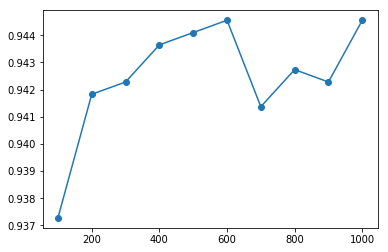

In [168]:
fig, ax = plt.subplots(1, 1)
ax.plot(n_estimators, scores, marker='o');

In [187]:
rand_opt = RandomForestClassifier(n_estimators=600)
rand_opt.fit(X_train, y_train)
preds = rand_opt.predict(X_test)
print(accuracy_score(y_test, preds))

0.8875


## GradientBoosting

In [184]:
param_grid = {
    "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
    "min_child_weight" : [ 1, 3, 5, 7],
    "gamma"            : [ 0.0, 0.1, 0.2, 0.3, 0.4],
    "colsample_bytree" : [ 0.3, 0.4, 0.5, 0.7]
}

xgb_grid = RandomizedSearchCV(
    estimator=XGBClassifier(), 
    param_distributions=param_grid,
    n_iter=100,
    cv=3,
    n_jobs=-1
)

# xgb_grid = GridSearchCV(
#     estimator=XGBClassifier(), 
#     param_grid=param_grid,
#     cv=3,
#     n_jobs=-1
# )

xgb_grid.fit(X_train, y_train)
print(xgb_grid.best_estimator_)

print("Performance vs base model")
xgb_best = xgb_grid.best_estimator_.fit(X_train, y_train)
xgb_base = XGBClassifier().fit(X_train, y_train)

print("Base model f1: {}".format(accuracy_score(y_test, xgb_base.predict(X_test))))
print("Best model f1: {}".format(accuracy_score(y_test, xgb_best.predict(X_test))))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.4,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=3, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
Performance vs base model
Base model f1: 0.828125
Best model f1: 0.875


In [172]:
scores = []
n_estimators = np.arange(100, 1100, 100)
for i in n_estimators:
    mod = XGBClassifier(n_estimators=i, colsample_bylevel=1, colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, min_child_weight=1)
    cv_mean = np.mean(cross_val_score(mod, X_train, y_train, cv=3, scoring="accuracy"))
    scores.append(cv_mean)

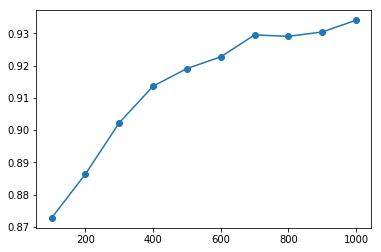

In [173]:
fig, ax = plt.subplots(1, 1)
ax.plot(n_estimators, scores, marker='o');

In [185]:
xgb_opt = XGBClassifier(n_estimators=1000, colsample_bylevel=1, colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, min_child_weight=1)
xgb_opt.fit(X_train, y_train)
preds = xgb_opt.predict(X_test)
print(accuracy_score(y_test, preds))

0.8875


In [186]:
## All features are adding value
pd.Series(xgb_opt.feature_importances_, X_train.columns).sort_values(ascending=False)

alcohol                 0.253465
sulphates               0.117479
citric acid             0.105151
density                 0.081349
volatile acidity        0.074745
total sulfur dioxide    0.074064
free sulfur dioxide     0.068025
chlorides               0.066355
fixed acidity           0.061438
residual sugar          0.049306
pH                      0.048624
dtype: float32